In [1]:
import re
import regex
import pandas as pd
import numpy as np
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
def startsWithDateAndTimeAndroid(s):
    pattern = r'''^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)'''
    result = re.match(pattern,s)
    if result:
        return True
    return False

In [3]:
def FindAuthor(s):
    s=s.split(":")
    if len(s)==2:
        return True
    else:
        return False

In [4]:
def getDataPointAndroid(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date,time = dateTime.split(', ')
    message = ' '.join(splitline[1:])
    if FindAuthor(message):
        splitMessage = message.split(':')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date,time,author,message

In [5]:
def getDataPointios(line):
    splitline = line.split('] ')
    datTime = splitline[0]
    if ',' in dateTime:
        date,time = dateTime.split(',')
    else:
        date,time = dateTime.split(' ')
    message = ' '.join(splitline[1:])
    if FindAuthor(message):
        splitMessage = message.split(':')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None 
    if time[5]==":":
        time = time[:5]+time[-3:]
    else:
        if 'AM' in time or 'PM' in time:
            time = time[:6]+time[-3:]
        else:
            time = time[:6]
    return date,time,author,message

In [6]:
def split_count(text):
    emoji_list = []
    emojis_iter = map(lambda y:y, emoki.UNICODE_EMOJI['en'].keys())
    regex_set = re.compile('|'.join(re.escape(em) for em in emojis_iter))
    emoji_list = regex_set.findall(text)
    return emoji_list

In [24]:
parsedData = []
conversationPath = 'Chatfile.txt'
with open(conversationPath, encoding="utf-8") as fp:
    device = ''
    first = fp.readline()
    print(first)
    if '[' in first:
        device = 'ios'
    else:
        device = 'android'
    fp.readline()
    messageBuffer = []
    date,time,author = None,None,None
    while True:
        line = fp.readline()
        if not line:
            break
        if device == 'ios':
            line = line.strip()
            if startsWithDateandTimeios(line):
                if len(messageBuffer)>0:
                    parsedData.append([date,time,author,' '.join(messageBuffer)])
                messageBuffer.clear()
                date,time,author,message = getDataPointios(line)
                messageBuffer.append(message)
            else:
                line = (line.encode('ascii','ignore')).decode("utf-8")
                if startsWithDateAndTimeios(line):
                    if len(messageBuffer)>0:
                        parsedData.append([date,time,author,' '.join(messageBuffer)])
                    messageBuffer.clear()
                    date,time,author,message = getDataPointios(line)
                    messageBuffer.append(message)
                else:
                    messageBuffer.append(line)
        else:
            line = line.strip()
            if startsWithDateAndTimeAndroid(line):
                if len(messageBuffer)>0:
                    parsedData.append([date,time,author,' '.join(messageBuffer)])
                messageBuffer.clear()
                date,time,author,message = getDataPointAndroid(line)
                messageBuffer.append(message)
            else:
                messageBuffer.append(line)      



17/09/24, 8:47 am -    Author:              Messages



In [25]:
#Checking File Location
import os
print(os.getcwd())

C:\Users\HP\Desktop\Chatilizer


In [26]:
#Checking file path is correct or not
import os
print(os.path.exists(conversationPath))

True


In [27]:
if device == 'android':
    df = pd.DataFrame(parsedData,columns=['Date','Time','Author','Message'])
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna()
    
    URLPATTERN = r'(https?://\S+)'
    df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN,x)).str.len()
else:
    df = pd.DataFrame(parsedData,columns = ['Date','Time','Author','Message'])
    df = df.dropna()
    df['Date'] = df['Date'].apply(dateconv)
    df['Date'] = pd.to_datetime(df['Date'],format = '%y-%m-%d')
    
    URLPATTERN = r'(https?://\S+)'
    df['urlcount'] = df.Message.apply(lambda x:re.findall(URLPATTERN,x)).str.len()




In [28]:
df.shape

(0, 5)

In [36]:
df.tail()

,Date,Time,Author,Message,urlcount


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      0 non-null      datetime64[ns]
 1   Time      0 non-null      object        
 2   Author    0 non-null      object        
 3   Message   0 non-null      object        
 4   urlcount  0 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 0.0+ bytes


In [23]:
df.Author.unique()

array([], dtype=object)

In [24]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      0 non-null      datetime64[ns]
 1   Time      0 non-null      object        
 2   Author    0 non-null      object        
 3   Message   0 non-null      object        
 4   urlcount  0 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 0.0+ bytes


In [25]:
total_messages = df.shape[0]
print(total_messages)

0


In [26]:
media_messages = df[df['Message']=='<Media omitted>'].shape[0]
print(media_messages)

0


In [27]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x:re.findall(URLPATTERN,x)).str.len() 
links = np.sum(df.urlcount)
print(links)

0


In [28]:
link_messages = df[df['urlcount']>0]
deleted_messages = df[(df["Message"] == "You deleted this message")| (df["Message"]=="This message was deleted.")]
media_messages_df = df[(df['Message'] == '<Media omitted>') | (df['Message'] == 'image omitted') | (df['Message'] == 'video omitted') | (df['Message'] == 'sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [29]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      0 non-null      datetime64[ns]
 1   Time      0 non-null      object        
 2   Author    0 non-null      object        
 3   Message   0 non-null      object        
 4   urlcount  0 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 0.0+ bytes


In [30]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s: len(s))
messages_df['word_count'] = messages_df['Message'].apply(lambda s: len(s.split(' ')))
messages_df['MessageCount'] = 1

In [31]:
messages_df.head(10)

,Date,Time,Author,Message,urlcount,Letter_Count,word_count,MessageCount


In [32]:
friends = messages_df.Author.unique()
for i in range(len(friends)):
    req_df = messages_df[messages_df['Author'] == friends[i]]
    print(f'stats of {friends[i]}-')
    print('Messages Sent', req_df.shape[0])

    words_per_message = (np.sum(req_df['word_count']))/req_df.shape[0]
    print('Words per message', words_per_message)

    media = media_messages_df[media_messages_df['Author'] == friends[i].shape[0]]
    print('Media Messages Sent', media)

    links = sum(link_messages[link_messages['Author'] == friends[i]]['urlcount'])
    print('Links Sent',links)
    print()


IndexError: index 0 is out of bounds for axis 0 with size 0

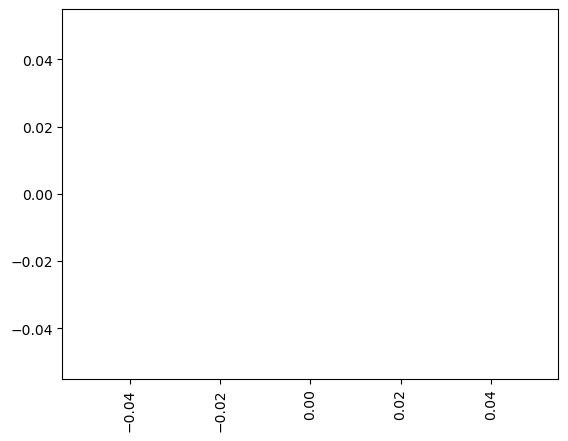

In [33]:
messages_df['Time'].value_counts().head(10).plot.bar()
plt.xlabel('Time')
plt.ylabel('number of messages')

In [34]:
text = " ".join(review for review in messages_df.Message)
print("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords = stopwords, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

There are 0 words in all the messages.


ValueError: We need at least 1 word to plot a word cloud, got 0.